### Image Classification Models - ResNet50

In [16]:
# reading train labels & removing duplicates
train_data = pd.read_csv('stage_2_train_labels.csv')
train_labels = train_data[['patientId','Target']].drop_duplicates()
train_labels.to_csv('train_labels.csv',index=False)

In [17]:
train_labels.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [27]:
pneumonia_present = train_labels[train_labels['Target']==1]
pneumonia_absent = train_labels[train_labels['Target']==0]

In [32]:
pneumonia_present_list = pneumonia_present['patientId'].to_list()
pneumonia_absent_list = pneumonia_absent['patientId'].to_list()

In [35]:
for i in range(len(pneumonia_present_list)):
    pneumonia_present_list[i] = pneumonia_present_list[i] + '.dcm'
    
for i in range(len(pneumonia_absent_list)):
    pneumonia_absent_list[i] = pneumonia_absent_list[i] + '.dcm'

In [44]:
# Convert DICOM to PNG via openCV
import cv2
import os
import pydicom
import glob

inputdir = 'C:/Users/ashwathi.subramanian/Desktop/Capstone/stage_2_train_images/'
outdir = 'C:/Users/ashwathi.subramanian/Desktop/Capstone/stage_2_train_images_png/pneumonia_present/'
os.mkdir(outdir)

train_list = pneumonia_present_list
    
print("The number of training images found is:",len(train_list))

for f in train_list:   
    ds = pydicom.read_file(inputdir + f) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + f.replace('.dcm','.png'),img) # write png image

The number of training images found is: 6012


In [45]:
# Convert DICOM to PNG via openCV
import cv2
import os
import pydicom
import glob

inputdir = 'C:/Users/ashwathi.subramanian/Desktop/Capstone/stage_2_train_images/'
outdir = 'C:/Users/ashwathi.subramanian/Desktop/Capstone/stage_2_train_images_png/pneumonia_absent/'
os.mkdir(outdir)

train_list = pneumonia_absent_list
    
print("The number of training images found is:",len(train_list))

for f in train_list:   
    ds = pydicom.read_file(inputdir + f) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + f.replace('.dcm','.png'),img) # write png image

The number of training images found is: 20672


In [61]:
# Convert DICOM to PNG via openCV
import cv2
import os
import pydicom
import glob

inputdir = 'C:/Users/ashwathi.subramanian/Desktop/Capstone/stage_2_test_images/'
outdir = 'C:/Users/ashwathi.subramanian/Desktop/Capstone/stage_2_test_images_png/'
# os.mkdir(outdir)

test_list = glob.glob(inputdir+'*')
for i in range(len(test_list)):
    test_list[i] = test_list[i].split('\\')[1]
print("The number of training images found is:",len(test_list))

for f in test_list:   
    ds = pydicom.read_file(inputdir + f) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + f.replace('.dcm','.png'),img) # write png image

The number of training images found is: 3000


In [96]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [81]:
# re-size all the images to this
IMAGE_SIZE = [128, 128]

train_path = 'C:/Users/ashwathi.subramanian/Desktop/Capstone/stage_2_train_images_png/'
test_path = 'C:/Users/ashwathi.subramanian/Desktop/Capstone/stage_2_test_images_png/'

In [84]:
# useful for getting number of output classes
n_classes = 2

In [89]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.25)

In [90]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset='training')

Found 20013 images belonging to 2 classes.


In [91]:
validation_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset='validation')

Found 6671 images belonging to 2 classes.


In [97]:
# Here we will be using imagenet weights
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [99]:
x = Flatten()(resnet.output)
prediction = Dense(2, activation='softmax')(x)
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False
# create a model object
resnet50_model = Model(inputs=resnet.input, outputs=prediction)

resnet50_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [100]:
resnet50_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [102]:
import time

StartTime = time.time()
r = resnet50_model.fit_generator(
  training_set,
  epochs=10,
  validation_data = validation_set,
  steps_per_epoch=len(training_set)
)
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/10
626/626 [==============================] - 3060s 5s/step - loss: 0.4945 - accuracy: 0.7731 - val_loss: 0.4622 - val_accuracy: 0.7763
Epoch 2/10
626/626 [==============================] - 2222s 4s/step - loss: 0.4713 - accuracy: 0.7802 - val_loss: 0.4903 - val_accuracy: 0.7754
Epoch 3/10
626/626 [==============================] - 1905s 3s/step - loss: 0.4648 - accuracy: 0.7813 - val_loss: 0.4397 - val_accuracy: 0.7990
Epoch 4/10
626/626 [==============================] - 1889s 3s/step - loss: 0.4659 - accuracy: 0.7800 - val_loss: 0.5162 - val_accuracy: 0.7760
Epoch 5/10
626/626 [==============================] - 1890s 3s/step - loss: 0.4596 - accuracy: 0.7848 - val_loss: 0.4412 - val_accuracy: 0.7933
Epoch 6/10
626/626 [==============================] - 2003s 3s/step - loss: 0.4614 - accuracy: 0.7865 - val_loss: 0.4380 - val_accuracy: 0.7964
Epoch 7/10
626/626 [==============================] - 1899s 3s/step - loss: 0.4569 - accuracy: 0.7886 - val_loss: 0.4562 - val_accuracy:

In [103]:
results = resnet50_model.evaluate(validation_set)
print('Validation accuracy using ResNet50 is : ', results[1]*100,'%')

209/209 [==============================] - 652s 3s/step - loss: 0.4351 - accuracy: 0.7993
Validation accuracy using ResNet50 is :  79.92804646492004 %


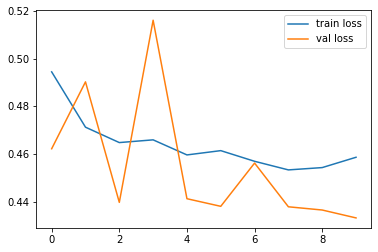

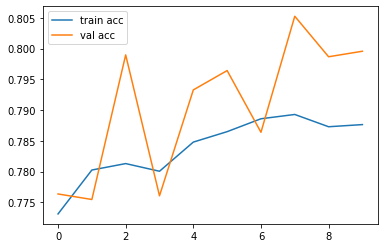

<Figure size 432x288 with 0 Axes>

In [104]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [106]:
# save it as a pickle file
from tensorflow.keras.models import load_model
resnet50_model.save('resnet50_model.pkl')

INFO:tensorflow:Assets written to: resnet50_model.pkl\assets


INFO:tensorflow:Assets written to: resnet50_model.pkl\assets
